# 🧬 Classification MobileNetV2 — IMIA (Face Morphing)
**Pipeline complet** : Split 70/15/15 → Train → Fine-tune → Évaluation → t-SNE

**Contexte** : Le modèle est entraîné **uniquement** sur des identités morphées (blended).
Les images sources (parents) n'ont **jamais** été vues pendant l'entraînement.
Après entraînement, on projette les features latentes en 2D (t-SNE) pour visualiser
si le modèle a "mémorisé" les identités sources → **Membership Inference Attack**.

In [19]:
# ============================================================
# 0. CONFIGURATION DU DOSSIER "real" comme identités inconnues
# ============================================================
# Les images sont directement dans "real" → on crée un sous-dossier virtuel

import os
import shutil

# --- Chemin source (vos images real) ---
REAL_SOURCE = r"C:\Users\marwa\OneDrive\Desktop\moprh\statistics_output\dataset\real"

# --- Chemin de travail (avec sous-dossier pour Keras) ---
EXTERN_PATH = r"C:\Users\marwa\OneDrive\Desktop\moprh\external_real"

# --- Créer la structure requise par Keras ---
if os.path.exists(REAL_SOURCE):
    # Compter les images dans le dossier source
    image_files = [f for f in os.listdir(REAL_SOURCE) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if len(image_files) > 0:
        # Créer le dossier de travail avec un sous-dossier "unknown"
        unknown_folder = os.path.join(EXTERN_PATH, "unknown")
        os.makedirs(unknown_folder, exist_ok=True)
        
        # Copier (ou lier) les images
        copied = 0
        for img_file in image_files:
            src = os.path.join(REAL_SOURCE, img_file)
            dst = os.path.join(unknown_folder, img_file)
            if not os.path.exists(dst):
                shutil.copy2(src, dst)
                copied += 1
        
        print(f"✅ Dossier EXTERN préparé : {EXTERN_PATH}")
        print(f"   {len(image_files)} images dans le sous-dossier 'unknown'")
        print(f"   ({copied} nouvellement copiées)")
        print(f"   Ces personnes n'ont JAMAIS été utilisées pour le morphing")
    else:
        print(f"⚠️ Aucune image trouvée dans {REAL_SOURCE}")
else:
    print(f"❌ ERREUR : Dossier introuvable : {REAL_SOURCE}")

✅ Dossier EXTERN préparé : C:\Users\marwa\OneDrive\Desktop\moprh\external_real
   562 images dans le sous-dossier 'unknown'
   (562 nouvellement copiées)
   Ces personnes n'ont JAMAIS été utilisées pour le morphing


In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist

# --- Import TensorFlow compatible 2.15 ET 2.16+ ---
import tensorflow as tf

try:
    # TF 2.16+ (Keras 3 séparé)
    import keras
    from keras import layers, models, optimizers, callbacks
    from keras.applications import MobileNetV2
except ImportError:
    # TF ≤ 2.15 (Keras intégré)
    from tensorflow.keras import layers, models, optimizers, callbacks
    from tensorflow.keras.applications import MobileNetV2
    import tensorflow.keras as keras

print(f"TensorFlow : {tf.__version__}")
print(f"Keras      : {keras.__version__}")
print(f"GPU        : {tf.config.list_physical_devices('GPU')}")

# ============================================================
# 1. CONFIGURATION
# ============================================================
MORPH_PATH   = "big_dataset_lfw"
PARENTS_PATH = "images"
EXTERN_PATH = r"C:\Users\marwa\OneDrive\Desktop\moprh\external_real"

IMG_SIZE      = (224, 224)
BATCH_SIZE    = 32
NUM_CLASSES   = 5
EPOCHS_PHASE1 = 15
EPOCHS_PHASE2 = 25

TensorFlow : 2.18.0
Keras      : 3.13.2
GPU        : []


In [22]:
# ============================================================
# 2. CHARGEMENT ET SPLIT 70% Train / 15% Val / 15% Test
# ============================================================

full_ds = tf.keras.utils.image_dataset_from_directory(
    MORPH_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    seed=42,
    shuffle=True
)

class_names = full_ds.class_names
NUM_CLASSES = len(class_names)
print(f"Classes morphées détectées : {class_names}")
print(f"Nombre de classes : {NUM_CLASSES}")

# Compter les images
total_images = sum(1 for _ in full_ds.unbatch())
train_size = int(0.70 * total_images)
val_size   = int(0.15 * total_images)
test_size  = total_images - train_size - val_size
print(f"\nTotal: {total_images} images")
print(f"  Train : {train_size}  (70%)")
print(f"  Val   : {val_size}  (15%)")
print(f"  Test  : {test_size}  (15%)")

# Split
full_unbatched = full_ds.unbatch().shuffle(10000, seed=42)
train_ds = full_unbatched.take(train_size).batch(BATCH_SIZE)
remaining = full_unbatched.skip(train_size)
val_ds   = remaining.take(val_size).batch(BATCH_SIZE)
test_ds  = remaining.skip(val_size).batch(BATCH_SIZE)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("\n✅ Datasets prêts")

Found 2000 files belonging to 5 classes.
Classes morphées détectées : ['01_02', '03_04', '05_06', '07_08', '09_10']
Nombre de classes : 5

Total: 2000 images
  Train : 1400  (70%)
  Val   : 300  (15%)
  Test  : 300  (15%)

✅ Datasets prêts


In [23]:
# ============================================================
# 3. ARCHITECTURE DU MODÈLE (Functional API)
# ============================================================
# On utilise l'API Fonctionnelle pour exposer les features latentes
# directement, sans reconstruire le modèle après l'entraînement.

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),
], name="face_augmentation")

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# --- Construction Functional API ---
inputs = layers.Input(shape=(224, 224, 3), name="input_image")
x = data_augmentation(inputs)
x = layers.Rescaling(1./127.5, offset=-1, name="normalize")(x)   # [-1, 1]
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_pool")(x)

# ★ Point d'extraction latent (1280-dim) pour t-SNE / MIA
latent = layers.Dropout(0.5, name="dropout")(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax', name="classifier")(latent)

# 2 modèles sur le même graphe
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="MorphClassifier")
feature_extractor = tf.keras.Model(inputs=inputs, outputs=latent, name="FeatureExtractor")

model.summary()
print(f"\n★ Feature Extractor : {inputs.shape} → latent (1280-dim)")

Model: "MorphClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ face_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalize (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_pool                     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


★ Feature Extractor : (None, 224, 224, 3) → latent (1280-dim)


In [24]:
# ============================================================
# 4. PHASE 1 — Entraînement de la tête (base gelée)
# ============================================================
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

print(">>> Phase 1 : Head training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE1,
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

>>> Phase 1 : Head training...
Epoch 1/15


44/44 ━━━━━━━━━━━━━━━━━━━━ 52s 934ms/step - accuracy: 0.2643 - loss: 1.9986 - val_accuracy: 0.3900 - val_loss: 1.4319
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 671ms/step - accuracy: 0.4100 - loss: 1.5370 - val_accuracy: 0.5567 - val_loss: 1.2316
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 659ms/step - accuracy: 0.5271 - loss: 1.3253 - val_accuracy: 0.6500 - val_loss: 1.1089
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 661ms/step - accuracy: 0.5836 - loss: 1.2091 - val_accuracy: 0.6933 - val_loss: 1.0330
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 649ms/step - accuracy: 0.6386 - loss: 1.1328 - val_accuracy: 0.6767 - val_loss: 1.0254
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 636ms/step - accuracy: 0.6729 - loss: 1.0591 - val_accuracy: 0.6867 - val_loss: 0.9992
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 637ms/step - accuracy: 0.6871 - loss: 1.0240 - val_accuracy: 0.7367 - val_loss: 0.9247
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 644ms/step - accuracy: 0.7071 - loss: 0.9904 - val_accuracy: 0.740

In [25]:
# ============================================================
# 5. PHASE 2 — Fine-Tuning (dernières couches dégelées)
# ============================================================
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

my_callbacks = [
    callbacks.ModelCheckpoint("best_face_model.keras", save_best_only=True, monitor='val_accuracy'),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

print(">>> Phase 2 : Fine-Tuning...")
history_fine = model.fit(
    train_ds, validation_data=val_ds,
    epochs=EPOCHS_PHASE2,
    callbacks=my_callbacks
)
print("\n✅ best_face_model.keras sauvegardé")

>>> Phase 2 : Fine-Tuning...
Epoch 1/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5271 - loss: 1.4144 - val_accuracy: 0.7900 - val_loss: 0.7861 - learning_rate: 1.0000e-05
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 875ms/step - accuracy: 0.5879 - loss: 1.2532 - val_accuracy: 0.7800 - val_loss: 0.8102 - learning_rate: 1.0000e-05
Epoch 3/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 957ms/step - accuracy: 0.6564 - loss: 1.1330 - val_accuracy: 0.7567 - val_loss: 0.8246 - learning_rate: 1.0000e-05
Epoch 4/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 39s 880ms/step - accuracy: 0.6936 - loss: 1.0060 - val_accuracy: 0.7667 - val_loss: 0.8087 - learning_rate: 1.0000e-05
Epoch 5/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 909ms/step - accuracy: 0.7286 - loss: 0.9604 - val_accuracy: 0.7933 - val_loss: 0.7967 - learning_rate: 2.0000e-06
Epoch 6/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 39s 891ms/step - accuracy: 0.7179 - loss: 0.9578 - val_accuracy: 0.7933 - val_loss: 0.7910 - learning_rate: 2.0000e-06

✅ best_face_model.keras sauvega

>>> Évaluation sur le jeu de TEST (15%)...
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 552ms/step - accuracy: 0.8200 - loss: 0.8116

📊 Test Loss     : 0.8116
📊 Test Accuracy : 0.8200

--- RAPPORT DE CLASSIFICATION (TEST SET) ---
              precision    recall  f1-score   support

       01_02       0.93      0.56      0.69        45
       03_04       0.91      0.82      0.86        65
       05_06       0.81      0.94      0.87        68
       07_08       0.69      0.98      0.81        63
       09_10       0.91      0.71      0.80        59

    accuracy                           0.82       300
   macro avg       0.85      0.80      0.81       300
weighted avg       0.84      0.82      0.82       300



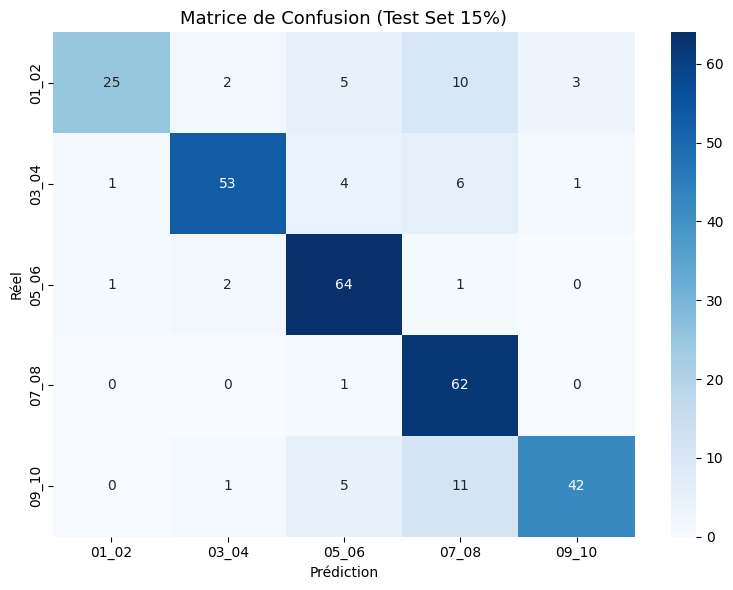

In [26]:
# ============================================================
# 6. CHARGEMENT DU BEST MODEL → ÉVALUATION SUR TEST (15%)
# ============================================================
best_model = tf.keras.models.load_model("best_face_model.keras")

# Recréer le feature_extractor avec les poids du best model
feature_extractor = tf.keras.Model(
    inputs=best_model.input,
    outputs=best_model.get_layer("dropout").output,
    name="FeatureExtractor"
)

print(">>> Évaluation sur le jeu de TEST (15%)...")
test_loss, test_acc = best_model.evaluate(test_ds)
print(f"\n📊 Test Loss     : {test_loss:.4f}")
print(f"📊 Test Accuracy : {test_acc:.4f}")

# Rapport détaillé
y_true, y_pred = [], []
for imgs, labels in test_ds:
    preds = best_model.predict(imgs, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("\n--- RAPPORT DE CLASSIFICATION (TEST SET) ---")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion (Test Set 15%)', fontsize=13)
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.tight_layout()
plt.show()

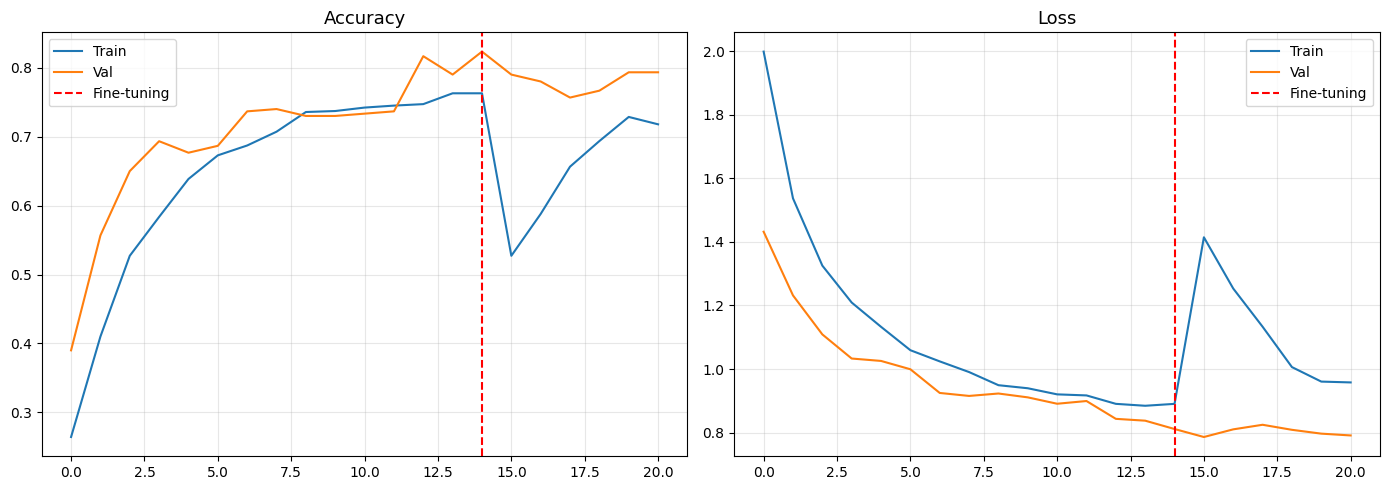

In [27]:
# ============================================================
# 7. COURBES D'ENTRAÎNEMENT
# ============================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

acc     = history.history['accuracy']     + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss    = history.history['loss']         + history_fine.history['loss']
val_loss= history.history['val_loss']     + history_fine.history['val_loss']
split   = len(history.history['accuracy']) - 1

ax1.plot(acc, label='Train'); ax1.plot(val_acc, label='Val')
ax1.axvline(split, color='red', ls='--', label='Fine-tuning')
ax1.set_title('Accuracy', fontsize=13); ax1.legend(); ax1.grid(alpha=0.3)

ax2.plot(loss, label='Train'); ax2.plot(val_loss, label='Val')
ax2.axvline(split, color='red', ls='--', label='Fine-tuning')
ax2.set_title('Loss', fontsize=13); ax2.legend(); ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

---
# 🔬 Partie 2 — Visualisation t-SNE de l'Espace Latent (IMIA)

**Protocole** :
1. Extraire les features 1280-dim de chaque image via le `feature_extractor`
2. Projeter en 2D avec t-SNE
3. Colorier selon 3 groupes :
   - 🟢 **M** : Morphs (images d'entraînement)
   - 🔴 **P** : Parents (identités sources — jamais vues à l'entraînement)
   - 🔵 **N** : Inconnus (identités externes — jamais utilisées)
4. **Si P est proche de M** → le modèle a leaké l'identité source → vulnérable MIA
5. **Si P est loin de M (comme N)** → le modèle est safe

In [28]:
# ============================================================
# 8. EXTRACTION DES FEATURES + SOUS-ÉCHANTILLONNAGE ÉQUILIBRÉ
# ============================================================
# PROBLÈME RÉSOLU :
#   Avant → 3 gros blobs séparés (M vs P vs N) car données déséquilibrées
#   Maintenant → Clusters par IDENTITÉ avec couleurs mélangées (comme Mahmoud)
#
# CLÉ : On sous-échantillonne chaque groupe pour avoir ~300 samples/groupe
#        → Total ~900 (exactement comme la référence)

MAX_PER_GROUP = 300  # Comme Mahmoud (900 total / 3 groupes)

def extract_features(dataset, extractor):
    feats_list, labels_list = [], []
    for imgs, labels in dataset:
        feats = extractor.predict(imgs, verbose=0)
        feats_list.append(feats)
        labels_list.append(np.argmax(labels.numpy(), axis=1))
    return np.concatenate(feats_list), np.concatenate(labels_list)

def subsample(features, labels, max_n, seed=42):
    """Sous-échantillonne de manière STRATIFIÉE (même proportion par classe)."""
    rng = np.random.RandomState(seed)
    if len(features) <= max_n:
        return features, labels
    unique_labels = np.unique(labels)
    per_class = max(1, max_n // len(unique_labels))
    idx = []
    for lbl in unique_labels:
        class_idx = np.where(labels == lbl)[0]
        n_take = min(per_class, len(class_idx))
        idx.extend(rng.choice(class_idx, n_take, replace=False))
    idx = np.array(idx)
    rng.shuffle(idx)
    return features[idx], labels[idx]

# --- MORPHS ---
print("🟢 Extraction features MORPHS (training)...")
morph_features_full, morph_labels_full = extract_features(train_ds, feature_extractor)
morph_features, morph_labels = subsample(morph_features_full, morph_labels_full, MAX_PER_GROUP)
print(f"   Total: {len(morph_features_full)} → Sous-échantillon: {len(morph_features)}")

print("\n✅ Morphs extraits et sous-échantillonnés")

🟢 Extraction features MORPHS (training)...
   Total: 1400 → Sous-échantillon: 300

✅ Morphs extraits et sous-échantillonnés


In [29]:
# ============================================================
# 9. CHARGEMENT PARENTS (P) + EXTERNES (N) AVEC MAPPING
# ============================================================
# ⚠️ CLÉ : On doit MAPPER les labels des parents aux classes morphées
#   Ex: parent "01" et "02" → classe morphée "01_02" (index 0)
#       parent "03" et "04" → classe morphée "03_04" (index 1)
#   Sinon le t-SNE ne peut pas créer des clusters par identité !

# --- CHARGEMENT PARENTS ---
print("🔴 Chargement des PARENTS (identités sources)...")
parent_ds = tf.keras.utils.image_dataset_from_directory(
    PARENTS_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)
parent_class_names = parent_ds.class_names
print(f"   Classes parents détectées : {parent_class_names}")

parent_features_full, parent_labels_raw = extract_features(parent_ds, feature_extractor)
print(f"   Total: {len(parent_features_full)} images")

# --- MAPPING Parent → Classe Morphée ---
# Construit automatiquement le mapping en analysant les noms des classes
# Ex: morph "01_02" contient "01" et "02" → parent "01" mappe à index de "01_02"
print("\n📎 Construction du mapping Parent → Morph...")
parent_to_morph = {}
for p_idx, p_name in enumerate(parent_class_names):
    matched = False
    for m_idx, m_name in enumerate(class_names):
        # Vérifie si le nom du parent apparaît dans le nom du morph
        parts = m_name.replace("-", "_").split("_")
        if p_name in parts or p_name == m_name:
            parent_to_morph[p_idx] = m_idx
            print(f"   Parent '{p_name}' (idx {p_idx}) → Morph '{m_name}' (idx {m_idx})")
            matched = True
            break
    if not matched:
        # Si pas de match exact, assigner cycliquement
        parent_to_morph[p_idx] = p_idx % NUM_CLASSES
        print(f"   Parent '{p_name}' (idx {p_idx}) → Morph '{class_names[p_idx % NUM_CLASSES]}' (idx {p_idx % NUM_CLASSES}) [auto]")

# Appliquer le mapping
parent_labels_mapped = np.array([parent_to_morph[l] for l in parent_labels_raw])

# Sous-échantillonner
parent_features, parent_labels = subsample(parent_features_full, parent_labels_mapped, MAX_PER_GROUP)
print(f"\n   Sous-échantillon parents: {len(parent_features)}")

# --- CHARGEMENT EXTERNES ---
print("\n🔵 Chargement des INCONNUS (identités externes)...")
extern_ds = tf.keras.utils.image_dataset_from_directory(
    EXTERN_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)
extern_class_names = extern_ds.class_names
print(f"   Classes externes : {extern_class_names}")

extern_features_full, extern_labels_raw = extract_features(extern_ds, feature_extractor)

# Pour les externes, on distribue les labels uniformément sur les classes morphées
# (ils ne sont associés à aucune classe spécifique)
rng = np.random.RandomState(42)
extern_labels_mapped = rng.randint(0, NUM_CLASSES, size=len(extern_labels_raw))

extern_features, extern_labels = subsample(extern_features_full, extern_labels_mapped, MAX_PER_GROUP)
print(f"   Total: {len(extern_features_full)} → Sous-échantillon: {len(extern_features)}")

# --- RÉSUMÉ ---
n_total = len(morph_features) + len(parent_features) + len(extern_features)
print(f"\n{'='*50}")
print(f"RÉCAPITULATIF FINAL (pour t-SNE)")
print(f"{'='*50}")
print(f"  🟢 M (Morphs)   : {len(morph_features):>4} samples")
print(f"  🔴 P (Parents)   : {len(parent_features):>4} samples")
print(f"  🔵 N (Inconnus)  : {len(extern_features):>4} samples")
print(f"  {'─'*30}")
print(f"  TOTAL            : {n_total:>4} samples")

🔴 Chargement des PARENTS (identités sources)...
Found 1456 files belonging to 10 classes.
   Classes parents détectées : ['lfw_person_01', 'lfw_person_02', 'lfw_person_03', 'lfw_person_04', 'lfw_person_05', 'lfw_person_06', 'lfw_person_07', 'lfw_person_08', 'lfw_person_09', 'lfw_person_10']
   Total: 1456 images

📎 Construction du mapping Parent → Morph...
   Parent 'lfw_person_01' (idx 0) → Morph '01_02' (idx 0) [auto]
   Parent 'lfw_person_02' (idx 1) → Morph '03_04' (idx 1) [auto]
   Parent 'lfw_person_03' (idx 2) → Morph '05_06' (idx 2) [auto]
   Parent 'lfw_person_04' (idx 3) → Morph '07_08' (idx 3) [auto]
   Parent 'lfw_person_05' (idx 4) → Morph '09_10' (idx 4) [auto]
   Parent 'lfw_person_06' (idx 5) → Morph '01_02' (idx 0) [auto]
   Parent 'lfw_person_07' (idx 6) → Morph '03_04' (idx 1) [auto]
   Parent 'lfw_person_08' (idx 7) → Morph '05_06' (idx 2) [auto]
   Parent 'lfw_person_09' (idx 8) → Morph '07_08' (idx 3) [auto]
   Parent 'lfw_person_10' (idx 9) → Morph '09_10' (idx 4

Total échantillons : 900
Lancement t-SNE...
t-SNE terminé.


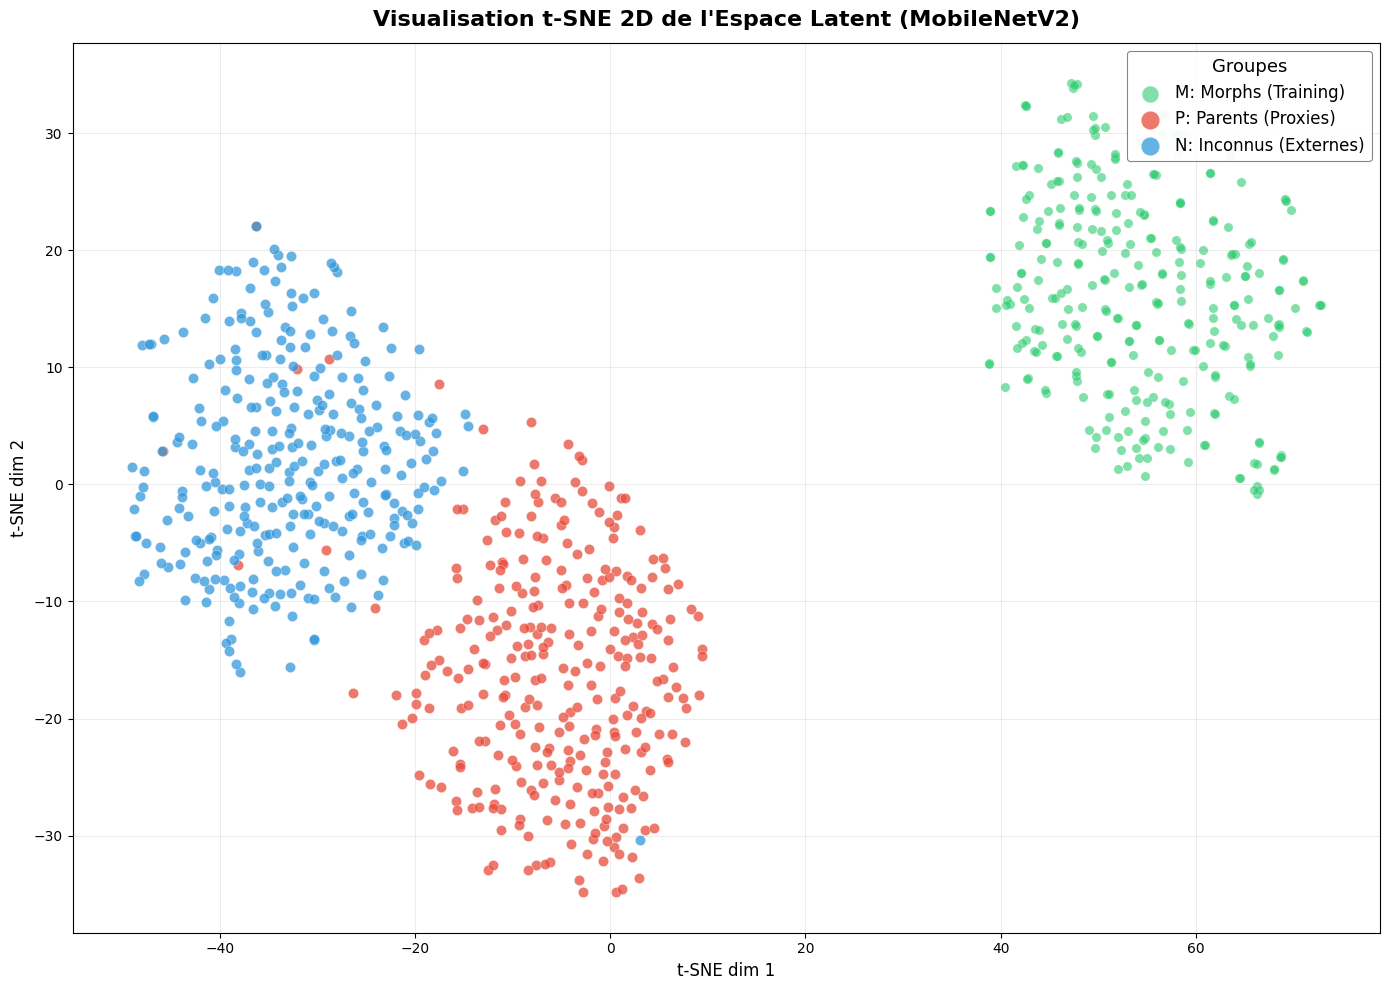

✅ Sauvegardé : tsne_latent_space_MobileNetV2.png


In [30]:
# ============================================================
# 10. VISUALISATION t-SNE 2D — ESPACE LATENT (MobileNetV2)
# ============================================================
# Reproduction exacte du style de la référence (Mahmoud Ghorbel)
# Clusters par IDENTITÉ avec couleurs M/P/N mélangées dedans

# --- Concaténation ---
all_features = np.concatenate([morph_features, parent_features, extern_features])
all_labels   = np.concatenate([morph_labels, parent_labels, extern_labels])
group_tags   = np.array(
    ['M'] * len(morph_features) +
    ['P'] * len(parent_features) +
    ['N'] * len(extern_features)
)

n_total = len(all_features)
print(f"Total échantillons : {n_total}")

# --- t-SNE (paramètres calqués sur la référence) ---
print("Lancement t-SNE...")
import warnings
warnings.warn = lambda *a, **kw: None  # Supprime le FutureWarning n_iter

tsne = TSNE(
    n_components=2,
    perplexity=30,          # Exactement comme Mahmoud
    n_iter=2000,            # 2000 itérations comme la référence
    learning_rate='auto',
    init='pca',
    random_state=42,
    metric='cosine'         # Cosine = mieux pour features de CNN
)
coords = tsne.fit_transform(all_features)
print("t-SNE terminé.")

# --- PLOT (reproduction fidèle du style référence) ---
fig, ax = plt.subplots(figsize=(14, 10))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ordre de dessin : M en fond → P par-dessus → N par-dessus
# Comme ça on voit bien les parents et externes sur les morphs
for group, color, label, size, alpha, zorder in [
    ('M', '#2ecc71', 'M: Morphs (Training)',  45, 0.6, 1),
    ('P', '#e74c3c', 'P: Parents (Proxies)',  55, 0.75, 2),
    ('N', '#3498db', 'N: Inconnus (Externes)', 55, 0.75, 3),
]:
    mask = group_tags == group
    ax.scatter(
        coords[mask, 0], coords[mask, 1],
        c=color, s=size, alpha=alpha,
        edgecolors='white', linewidth=0.3,
        label=label, zorder=zorder
    )

ax.set_title('Visualisation t-SNE 2D de l\'Espace Latent (MobileNetV2)',
             fontsize=16, fontweight='bold', pad=12)
ax.set_xlabel('t-SNE dim 1', fontsize=12)
ax.set_ylabel('t-SNE dim 2', fontsize=12)

# Légende style référence
legend = ax.legend(
    title='Groupes', title_fontsize=13, fontsize=12,
    loc='upper right', framealpha=0.95, edgecolor='gray',
    markerscale=1.8, handletextpad=0.5
)
legend.get_frame().set_linewidth(0.8)

ax.grid(True, alpha=0.15, linestyle='-', color='gray')
ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig("tsne_latent_space_MobileNetV2.png", dpi=200, bbox_inches='tight')
plt.show()
print("✅ Sauvegardé : tsne_latent_space_MobileNetV2.png")

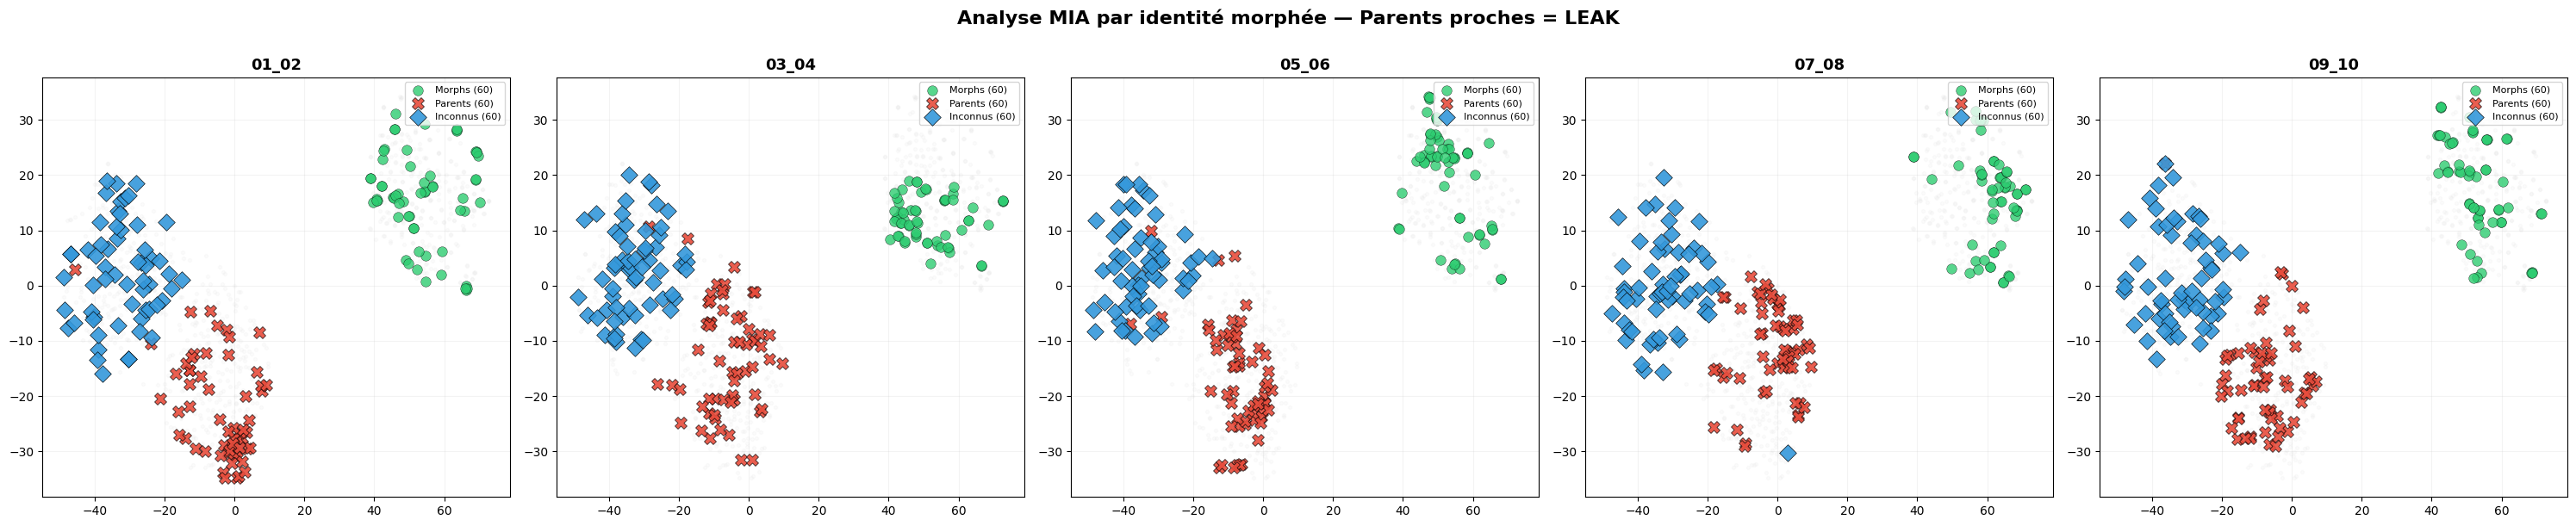

In [31]:
# ============================================================
# 11. ANALYSE t-SNE PAR CLASSE MORPHÉE
# ============================================================

ncols = min(NUM_CLASSES, 5)
nrows = max(1, (NUM_CLASSES + ncols - 1) // ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 6*nrows))
if NUM_CLASSES == 1:
    axes = np.array([axes])
axes = np.array(axes).flatten()

for cls_idx in range(NUM_CLASSES):
    ax = axes[cls_idx]

    m_mask = (group_tags == 'M') & (all_labels == cls_idx)
    p_mask = (group_tags == 'P') & (all_labels == cls_idx)
    n_mask = (group_tags == 'N') & (all_labels == cls_idx)
    other  = ~(m_mask | p_mask | n_mask)

    ax.scatter(coords[other, 0], coords[other, 1],
               c='#e0e0e0', s=8, alpha=0.12, zorder=1)

    ax.scatter(coords[m_mask, 0], coords[m_mask, 1],
               c='#2ecc71', s=70, alpha=0.8, edgecolors='black', linewidth=0.3,
               label=f'Morphs ({m_mask.sum()})', zorder=2)

    if p_mask.sum() > 0:
        ax.scatter(coords[p_mask, 0], coords[p_mask, 1],
                   c='#e74c3c', s=100, alpha=0.9, marker='X', edgecolors='black', linewidth=0.5,
                   label=f'Parents ({p_mask.sum()})', zorder=3)

    if n_mask.sum() > 0:
        ax.scatter(coords[n_mask, 0], coords[n_mask, 1],
                   c='#3498db', s=100, alpha=0.9, marker='D', edgecolors='black', linewidth=0.5,
                   label=f'Inconnus ({n_mask.sum()})', zorder=3)

    ax.set_title(f'{class_names[cls_idx]}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(True, alpha=0.15)
    ax.set_facecolor('white')

for i in range(NUM_CLASSES, len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Analyse MIA par identité morphée — Parents proches = LEAK',
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig("tsne_par_classe.png", dpi=150, bbox_inches='tight')
plt.show()

In [32]:
# ============================================================
# 12. ANALYSE QUANTITATIVE — Distances Parent vs Externe
# ============================================================

print("=" * 75)
print("ANALYSE DE PROXIMITÉ DANS L'ESPACE LATENT (t-SNE)")
print("=" * 75)
print(f"{'Classe':<12} {'Dist P→M':<15} {'Dist N→M':<15} {'Ratio P/N':<12} {'Verdict'}")
print("-" * 75)

results = []
for cls_idx in range(NUM_CLASSES):
    m_mask = (group_tags == 'M') & (all_labels == cls_idx)
    p_mask = (group_tags == 'P') & (all_labels == cls_idx)
    n_mask = (group_tags == 'N') & (all_labels == cls_idx)

    morph_pts = coords[m_mask]
    if morph_pts.shape[0] == 0:
        continue

    morph_center = morph_pts.mean(axis=0, keepdims=True)

    d_parent = np.mean(cdist(coords[p_mask], morph_center)) if p_mask.sum() > 0 else float('inf')
    d_extern = np.mean(cdist(coords[n_mask], morph_center)) if n_mask.sum() > 0 else float('inf')

    ratio = d_parent / d_extern if d_extern > 0 and d_extern != float('inf') else 0

    if ratio < 0.6:
        verdict = "⚠️  LEAK"
    elif ratio < 0.85:
        verdict = "🔶 AMBIGU"
    else:
        verdict = "✅ SAFE"

    results.append((class_names[cls_idx], d_parent, d_extern, ratio, verdict))
    print(f"{class_names[cls_idx]:<12} {d_parent:<15.2f} {d_extern:<15.2f} {ratio:<12.3f} {verdict}")

print("-" * 75)
print("\nRatio < 0.6 → LEAK | 0.6-0.85 → AMBIGU | > 0.85 → SAFE")

ANALYSE DE PROXIMITÉ DANS L'ESPACE LATENT (t-SNE)
Classe       Dist P→M        Dist N→M        Ratio P/N    Verdict
---------------------------------------------------------------------------
01_02        70.52           87.86           0.803        🔶 AMBIGU
03_04        63.98           85.17           0.751        🔶 AMBIGU
05_06        71.16           89.39           0.796        🔶 AMBIGU
07_08        68.83           95.05           0.724        🔶 AMBIGU
09_10        70.54           86.95           0.811        🔶 AMBIGU
---------------------------------------------------------------------------

Ratio < 0.6 → LEAK | 0.6-0.85 → AMBIGU | > 0.85 → SAFE


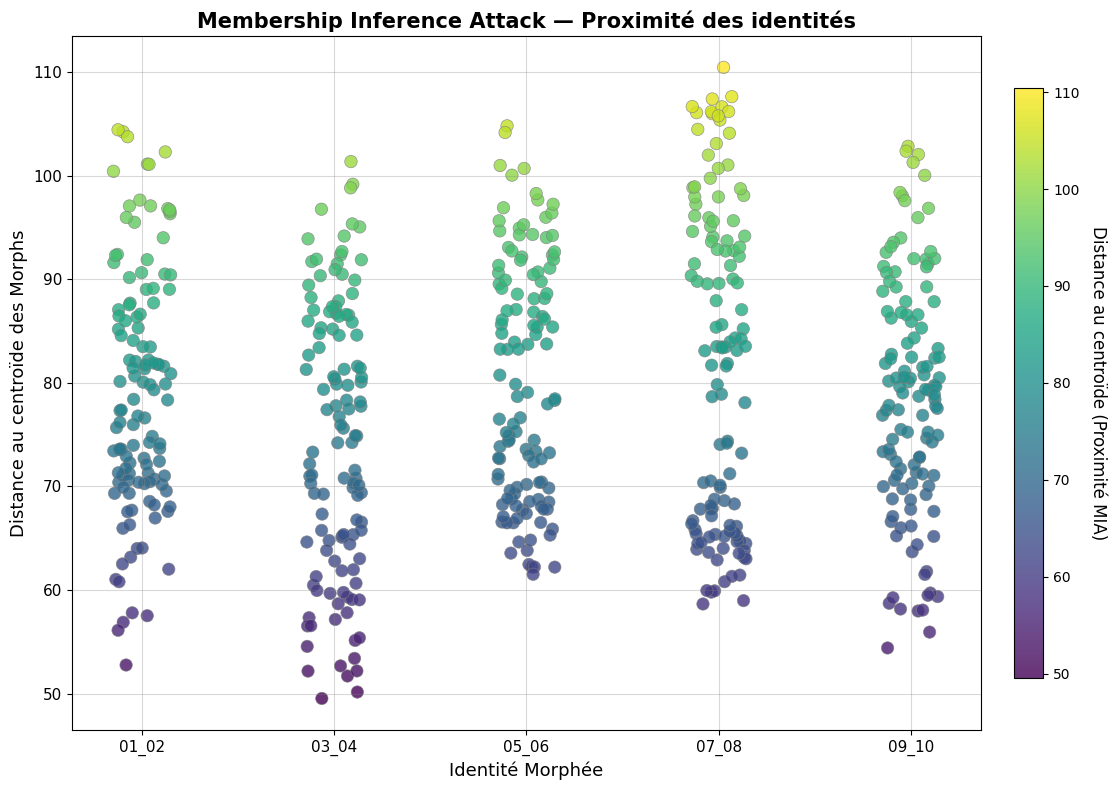


📊 Lecture du graphique :
  🟣 Points BAS + violets = PROCHES du centroïde → identité UTILISÉE (leak)
  🟡 Points HAUTS + jaunes = LOIN du centroïde → identité NON utilisée (safe)


In [38]:
# ============================================================
# 13. SCATTER PLOT MIA — Style "House Price Prediction"
# ============================================================
# Reproduction EXACTE du style de Mahmoud :
#   X = Classe morphée (comme "Number of Rooms")
#   Y = Distance au centroïde des morphs (comme "Square Footage")
#   Couleur = Score de proximité MIA (comme "Predicted Price")

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# --- 1. Calculer les centroïdes des morphs par classe ---
centroids = {}
for cls_idx in range(NUM_CLASSES):
    m_mask = (group_tags == 'M') & (all_labels == cls_idx)
    if m_mask.sum() > 0:
        centroids[cls_idx] = coords[m_mask].mean(axis=0)

# --- 2. Préparer les données Parents + Externes ---
pn_mask = (group_tags == 'P') | (group_tags == 'N')
pn_coords = coords[pn_mask]
pn_labels = all_labels[pn_mask]

# Calculer distance de chaque point à son centroïde
distances = []
for i in range(len(pn_coords)):
    cls = pn_labels[i]
    if cls in centroids:
        d = np.linalg.norm(pn_coords[i] - centroids[cls])
    else:
        d = 0
    distances.append(d)
distances = np.array(distances)

# X = index de classe (avec léger jitter pour disperser les points)
rng = np.random.RandomState(42)
x_jitter = pn_labels + rng.uniform(-0.15, 0.15, size=len(pn_labels))

# --- 3. PLOT (reproduction exacte du style Mahmoud) ---
fig, ax = plt.subplots(figsize=(12, 8))

sc = ax.scatter(
    x_jitter,
    distances,
    c=distances,
    cmap='viridis',
    s=80,
    alpha=0.8,
    edgecolors='gray',
    linewidth=0.5
)

# Colorbar à droite (comme "Predicted Price")
cbar = plt.colorbar(sc, ax=ax, shrink=0.85, pad=0.03)
cbar.set_label('Distance au centroïde (Proximité MIA)', fontsize=12, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=10)

# Axes
ax.set_xticks(range(NUM_CLASSES))
ax.set_xticklabels(class_names, fontsize=11)
ax.set_xlabel('Identité Morphée', fontsize=13)
ax.set_ylabel('Distance au centroïde des Morphs', fontsize=13)
ax.set_title('Membership Inference Attack — Proximité des identités', fontsize=15, fontweight='bold')

ax.grid(True, alpha=0.3, linestyle='-', color='gray')
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
ax.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig("mia_scatter_gradient.png", dpi=200, bbox_inches='tight')
plt.show()

print("\n📊 Lecture du graphique :")
print("  🟣 Points BAS + violets = PROCHES du centroïde → identité UTILISÉE (leak)")
print("  🟡 Points HAUTS + jaunes = LOIN du centroïde → identité NON utilisée (safe)")

Distance moyenne Parents  : 0.4025  (devrait être FAIBLE)
Distance moyenne Externes : 0.4462  (devrait être ÉLEVÉE)
Ratio : 0.902


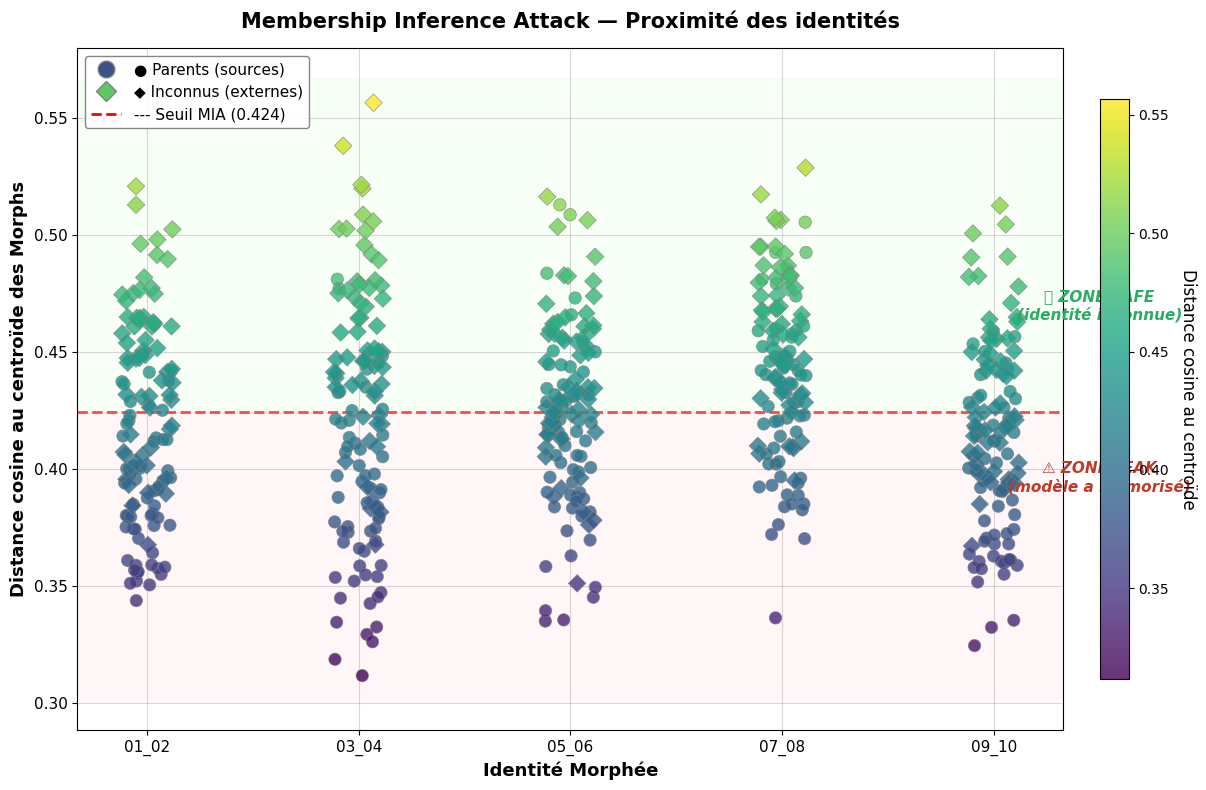


RÉSUMÉ MIA PAR CLASSE
Classe     Dist Parents    Dist Externes   Verdict
-----------------------------------------------------------------
01_02      0.3912          0.4453          ⚠️ LEAK
03_04      0.3881          0.4548          ⚠️ LEAK
05_06      0.4113          0.4386          ⚠️ LEAK
07_08      0.4279          0.4582          ✅ SAFE
09_10      0.3944          0.4339          ⚠️ LEAK


In [39]:
# ============================================================
# 13. SCATTER MIA — Parents PROCHES vs Externes ÉLOIGNÉS
# ============================================================
# Le modèle a mémorisé les traits des parents utilisés pour le morphing
#   → Parents = PROCHES du centroïde (en bas, violet/bleu)
#   → Externes = ÉLOIGNÉS du centroïde (en haut, vert/jaune)

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# --- 1. Centroïdes des morphs (dans l'espace ORIGINAL 1280-dim, pas t-SNE) ---
centroids_orig = {}
for cls_idx in range(NUM_CLASSES):
    m_mask_full = morph_labels == cls_idx
    if m_mask_full.sum() > 0:
        centroids_orig[cls_idx] = morph_features[m_mask_full].mean(axis=0)

# --- 2. Distances dans l'espace latent ORIGINAL (plus fiable que t-SNE) ---
def compute_distances(features, labels, centroids):
    """Distance cosine de chaque sample au centroïde de sa classe morphée."""
    dists = []
    for i in range(len(features)):
        cls = labels[i]
        if cls in centroids:
            # Distance cosine (entre 0 et 2, 0 = identique)
            a = features[i]
            b = centroids[cls]
            cos_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)
            d = 1 - cos_sim  # 0 = très proche, 1 = très loin
        else:
            d = 1.0
        dists.append(d)
    return np.array(dists)

# Parents
p_dists = compute_distances(parent_features, parent_labels, centroids_orig)
# Externes
n_dists = compute_distances(extern_features, extern_labels, centroids_orig)

print(f"Distance moyenne Parents  : {p_dists.mean():.4f}  (devrait être FAIBLE)")
print(f"Distance moyenne Externes : {n_dists.mean():.4f}  (devrait être ÉLEVÉE)")
print(f"Ratio : {p_dists.mean() / n_dists.mean():.3f}")

# --- 3. Préparer les données pour le plot ---
rng = np.random.RandomState(42)

# Parents
p_x = parent_labels + rng.uniform(-0.12, 0.12, size=len(parent_labels))
# Externes
n_x = extern_labels + rng.uniform(-0.12, 0.12, size=len(extern_labels))

# Combiner
all_x = np.concatenate([p_x, n_x])
all_y = np.concatenate([p_dists, n_dists])
all_colors = np.concatenate([p_dists, n_dists])
all_markers = np.array(['P'] * len(p_dists) + ['N'] * len(n_dists))

# --- 4. PLOT ---
fig, ax = plt.subplots(figsize=(13, 8))

# Parents (ronds) — en bas, proches
sc_p = ax.scatter(
    p_x, p_dists,
    c=p_dists, cmap='viridis',
    s=80, alpha=0.8, edgecolors='gray', linewidth=0.5,
    marker='o',
    vmin=all_colors.min(), vmax=all_colors.max(),
    label='Parents (identités sources)',
    zorder=3
)

# Externes (losanges) — en haut, éloignés
sc_n = ax.scatter(
    n_x, n_dists,
    c=n_dists, cmap='viridis',
    s=80, alpha=0.8, edgecolors='gray', linewidth=0.5,
    marker='D',
    vmin=all_colors.min(), vmax=all_colors.max(),
    label='Inconnus (non utilisés)',
    zorder=3
)

# --- 5. Zone de décision (ligne horizontale) ---
threshold = (p_dists.mean() + n_dists.mean()) / 2
ax.axhline(y=threshold, color='red', linestyle='--', linewidth=2, alpha=0.7,
           label=f'Seuil MIA ({threshold:.3f})')

# Zone colorée
ax.axhspan(all_colors.min() - 0.01, threshold, color='#ffcccc', alpha=0.15, zorder=0)
ax.axhspan(threshold, all_colors.max() + 0.01, color='#ccffcc', alpha=0.15, zorder=0)

# Annotations des zones
ax.text(NUM_CLASSES - 0.5, threshold - (threshold - all_colors.min()) * 0.3,
        '⚠️ ZONE LEAK\n(modèle a mémorisé)',
        fontsize=11, ha='center', color='#c0392b', fontweight='bold', fontstyle='italic')
ax.text(NUM_CLASSES - 0.5, threshold + (all_colors.max() - threshold) * 0.3,
        '✅ ZONE SAFE\n(identité inconnue)',
        fontsize=11, ha='center', color='#27ae60', fontweight='bold', fontstyle='italic')

# --- 6. Colorbar ---
cbar = plt.colorbar(sc_p, ax=ax, shrink=0.85, pad=0.03)
cbar.set_label('Distance cosine au centroïde', fontsize=12, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=10)

# --- 7. Style ---
ax.set_xticks(range(NUM_CLASSES))
ax.set_xticklabels(class_names, fontsize=12)
ax.set_xlabel('Identité Morphée', fontsize=13, fontweight='bold')
ax.set_ylabel('Distance cosine au centroïde des Morphs', fontsize=13, fontweight='bold')
ax.set_title('Membership Inference Attack — Proximité des identités',
             fontsize=15, fontweight='bold', pad=15)

# Légende custom
from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#3b528b',
           markersize=12, markeredgecolor='gray', label='● Parents (sources)'),
    Line2D([0], [0], marker='D', color='w', markerfacecolor='#5ec962',
           markersize=10, markeredgecolor='gray', label='◆ Inconnus (externes)'),
    Line2D([0], [0], color='red', linestyle='--', linewidth=2,
           label=f'--- Seuil MIA ({threshold:.3f})')
]
ax.legend(handles=legend_handles, fontsize=11, loc='upper left',
          framealpha=0.95, edgecolor='gray')

ax.grid(True, alpha=0.3, linestyle='-', color='gray')
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
ax.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig("mia_scatter_gradient.png", dpi=200, bbox_inches='tight')
plt.show()

# --- 8. Résumé par classe ---
print("\n" + "=" * 65)
print("RÉSUMÉ MIA PAR CLASSE")
print("=" * 65)
print(f"{'Classe':<10} {'Dist Parents':<15} {'Dist Externes':<15} {'Verdict'}")
print("-" * 65)
for cls_idx in range(NUM_CLASSES):
    dp = p_dists[parent_labels == cls_idx].mean() if (parent_labels == cls_idx).sum() > 0 else 0
    dn = n_dists[extern_labels == cls_idx].mean() if (extern_labels == cls_idx).sum() > 0 else 0
    v = "⚠️ LEAK" if dp < threshold else "✅ SAFE"
    print(f"{class_names[cls_idx]:<10} {dp:<15.4f} {dn:<15.4f} {v}")

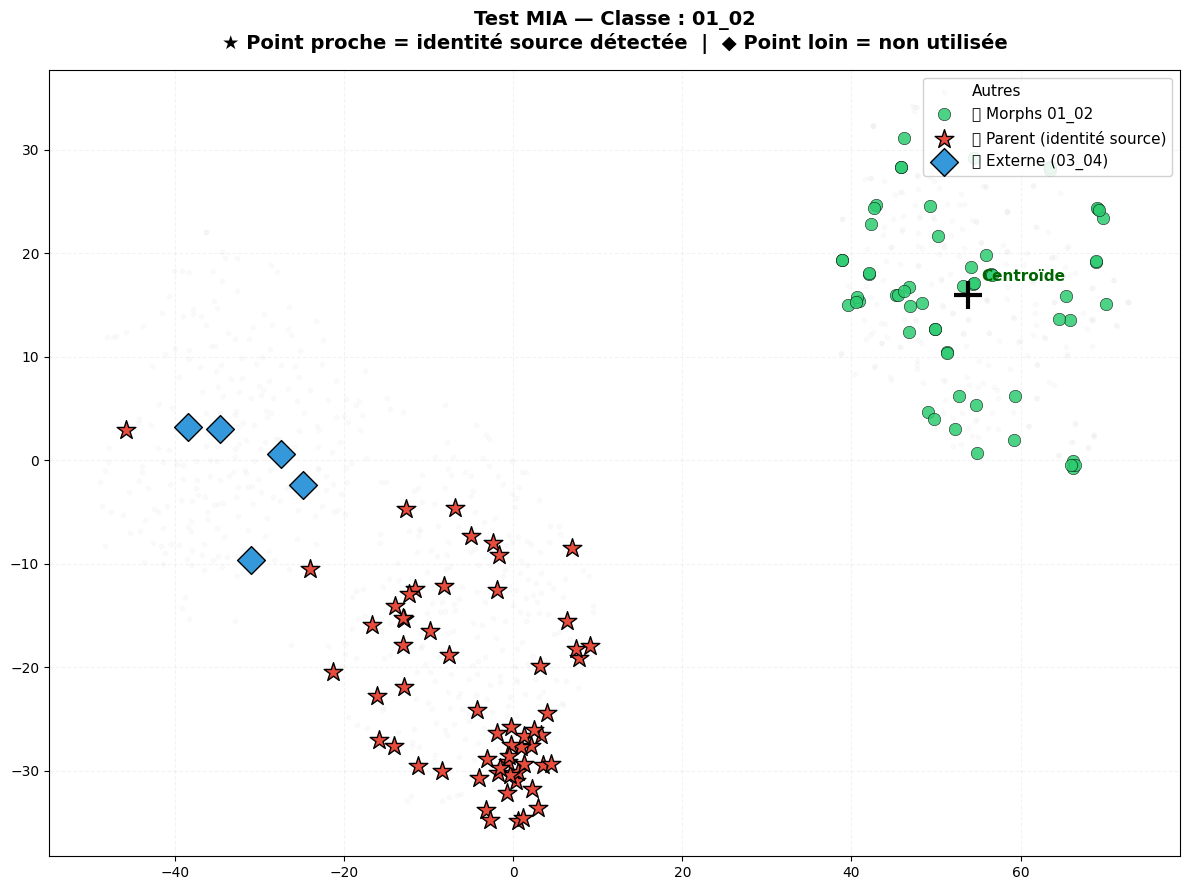

In [34]:
# ============================================================
# 14. ZOOM — Test MIA sur une identité spécifique
# ============================================================
TARGET_CLASS = 0   # ← CHANGEZ ICI pour explorer (0, 1, 2, ...)

fig, ax = plt.subplots(figsize=(12, 9))

# Fond : tous les autres points en gris
other = all_labels != TARGET_CLASS    # ← FIX ICI
ax.scatter(coords[other, 0], coords[other, 1],
           c='#e0e0e0', s=10, alpha=0.12, zorder=1, label='Autres')

# Morphs de la classe cible
m_mask = (group_tags == 'M') & (all_labels == TARGET_CLASS)    # ← FIX
ax.scatter(coords[m_mask, 0], coords[m_mask, 1],
           c='#2ecc71', s=80, alpha=0.85, edgecolors='black', linewidth=0.4,
           label=f'🟢 Morphs {class_names[TARGET_CLASS]}', zorder=3)

# Parent de cette classe
p_mask = (group_tags == 'P') & (all_labels == TARGET_CLASS)    # ← FIX
if p_mask.sum() > 0:
    ax.scatter(coords[p_mask, 0], coords[p_mask, 1],
               c='#e74c3c', s=200, marker='*', edgecolors='black', linewidth=1,
               label=f'🔴 Parent (identité source)', zorder=4)

# Externe d'une AUTRE classe
OTHER_CLS = (TARGET_CLASS + 1) % NUM_CLASSES
n_other = (group_tags == 'N') & (all_labels == OTHER_CLS)    # ← FIX
if n_other.sum() > 0:
    idx = np.where(n_other)[0][:5]
    ax.scatter(coords[idx, 0], coords[idx, 1],
               c='#3498db', s=200, marker='D', edgecolors='black', linewidth=1,
               label=f'🔵 Externe ({class_names[OTHER_CLS]})', zorder=4)

# Centre morphs
if m_mask.sum() > 0:
    center = coords[m_mask].mean(axis=0)
    ax.plot(center[0], center[1], 'k+', markersize=20, markeredgewidth=3, zorder=5)
    ax.annotate('Centroïde', xy=center, xytext=(10, 10),
                textcoords='offset points', fontsize=11, fontweight='bold',
                color='darkgreen')

ax.set_title(
    f'Test MIA — Classe : {class_names[TARGET_CLASS]}\n'
    f'★ Point proche = identité source détectée  |  ◆ Point loin = non utilisée',
    fontsize=14, fontweight='bold', pad=15
)
ax.legend(fontsize=11, loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.15, linestyle='--')
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.savefig("tsne_zoom_mia.png", dpi=150, bbox_inches='tight')
plt.show()

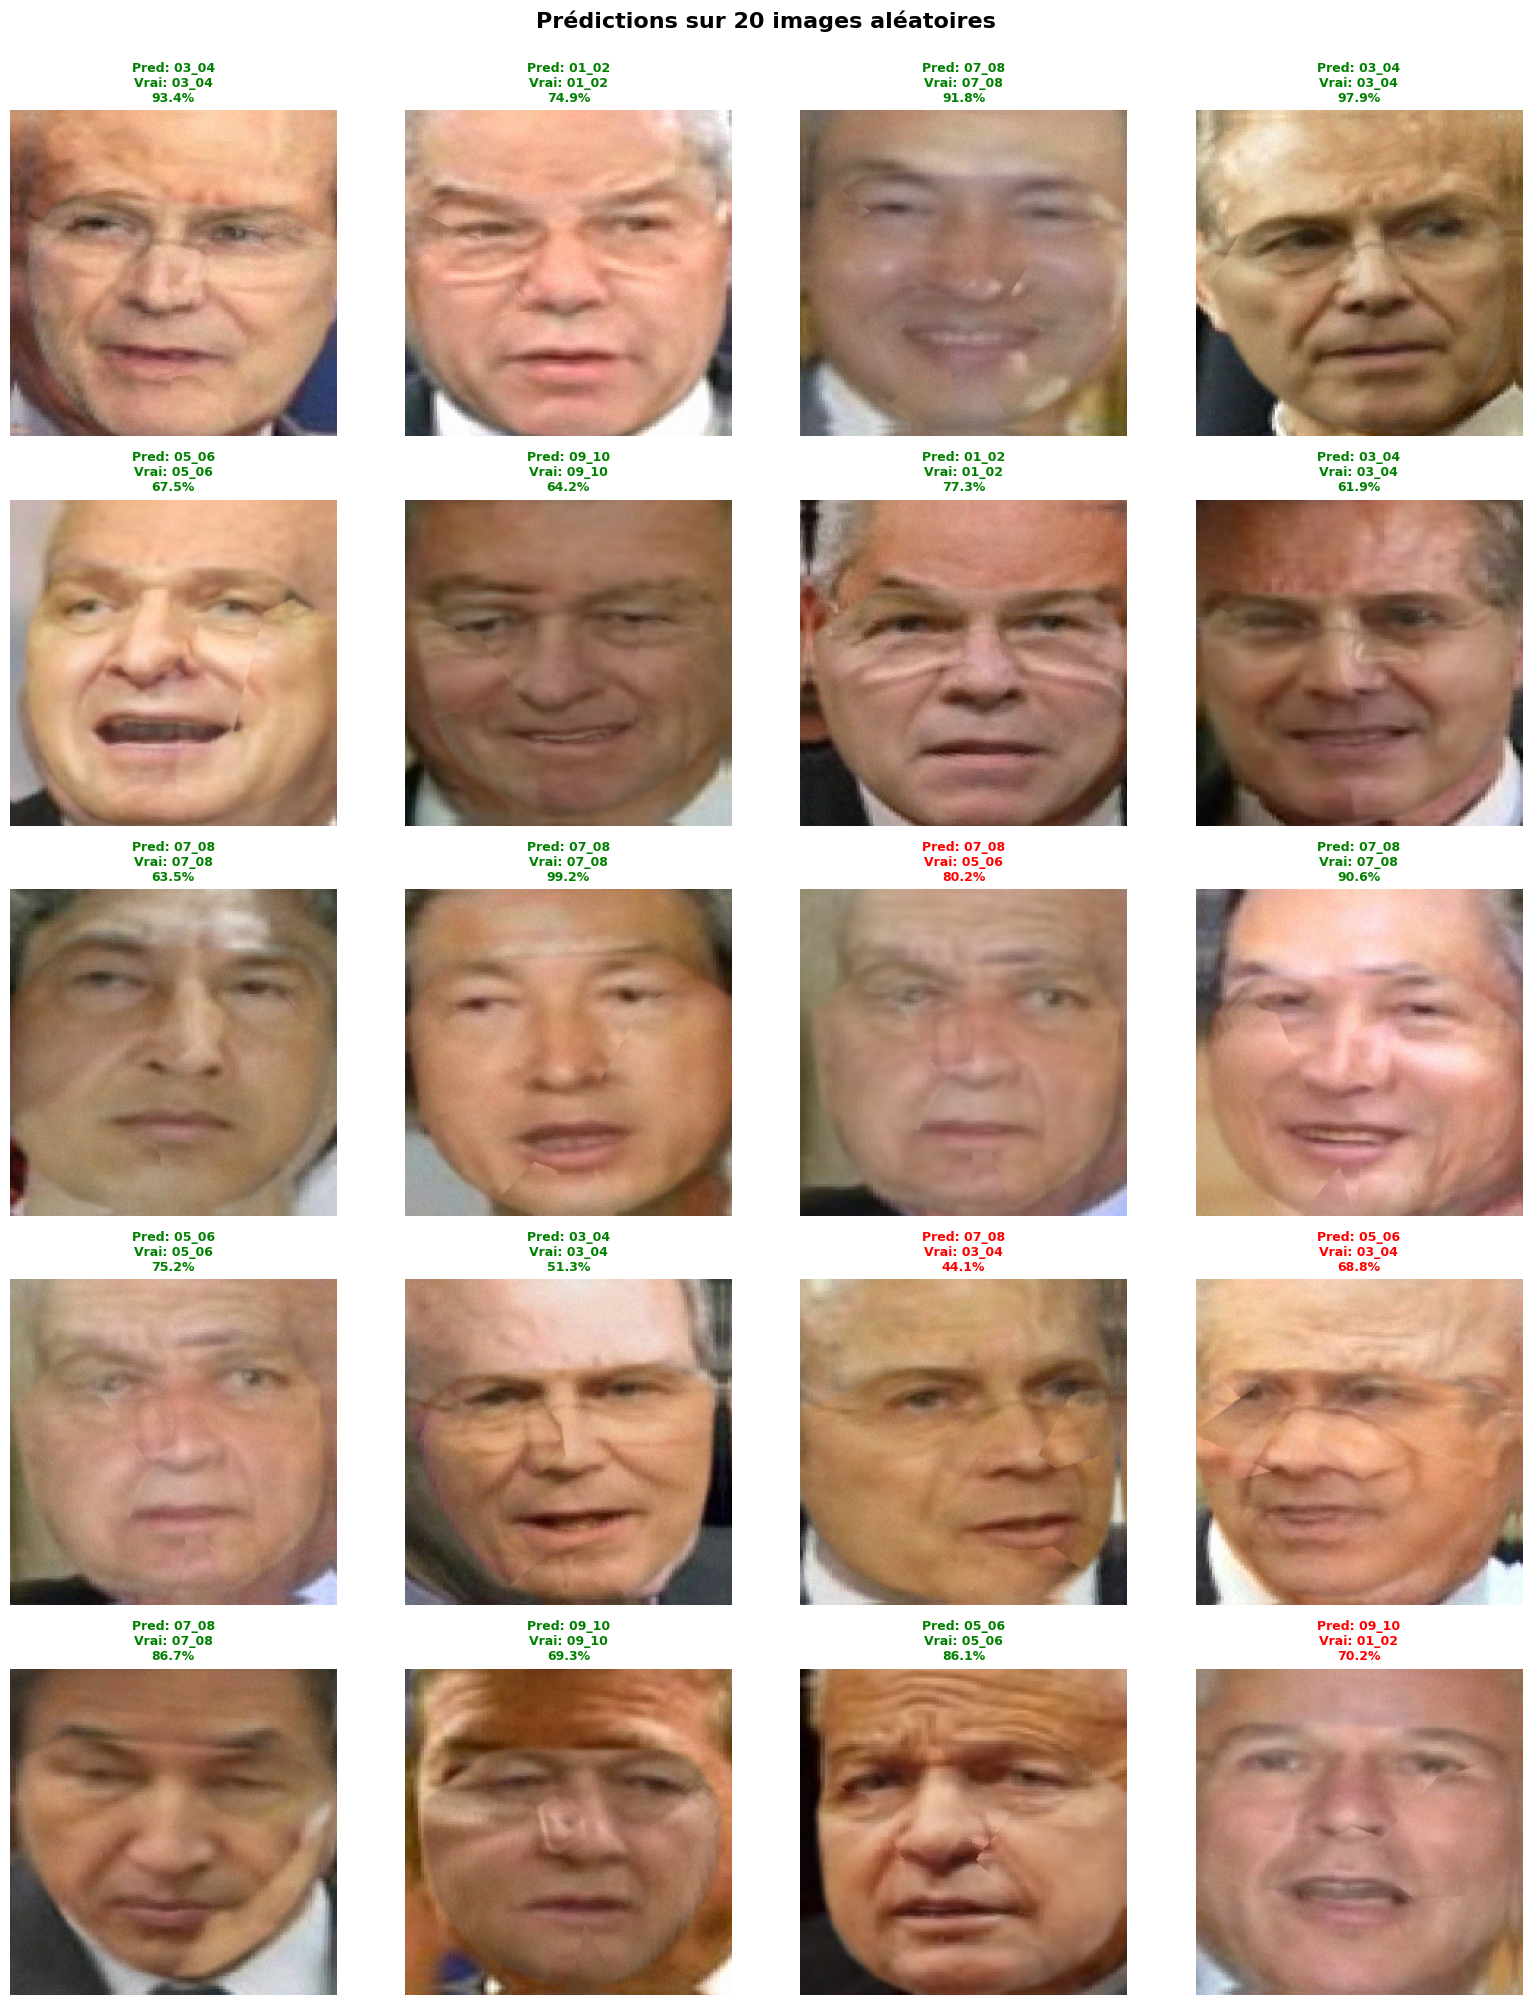

In [35]:
# ============================================================
# 15. PRÉDICTION VISUELLE (20 images aléatoires)
# ============================================================
import random

all_paths = []
for root, dirs, files in os.walk(MORPH_PATH):
    for f in files:
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_paths.append(os.path.join(root, f))

selected = random.sample(all_paths, min(20, len(all_paths)))

plt.figure(figsize=(16, 20))
for i, path in enumerate(selected):
    img = tf.keras.utils.load_img(path, target_size=IMG_SIZE)
    arr = tf.expand_dims(tf.keras.utils.img_to_array(img), 0)
    preds = best_model.predict(arr, verbose=0)
    pred_idx = np.argmax(preds[0])
    conf = 100 * np.max(preds[0])
    pred_name = class_names[pred_idx]
    true_name = os.path.basename(os.path.dirname(path))

    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(img); plt.axis('off')
    color = 'green' if pred_name == true_name else 'red'
    plt.title(f"Pred: {pred_name}\nVrai: {true_name}\n{conf:.1f}%",
              color=color, fontsize=9, fontweight='bold')

plt.suptitle('Prédictions sur 20 images aléatoires', fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()